In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# TP – Sélectionnez le nombre de voisins dans un kNN

In [3]:
data = pd.read_csv('winequality-white.csv', sep=";")
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
data.shape

(4898, 12)

Nous allons extraire deux arrays numpy de ces données, un qui contient les points et l’autre qui contient les étiquettes

In [6]:
X = data[data.columns[:-1]].values
y = data['quality'].values

On peut maintenant afficher un histogramme pour chacune de nos variables :

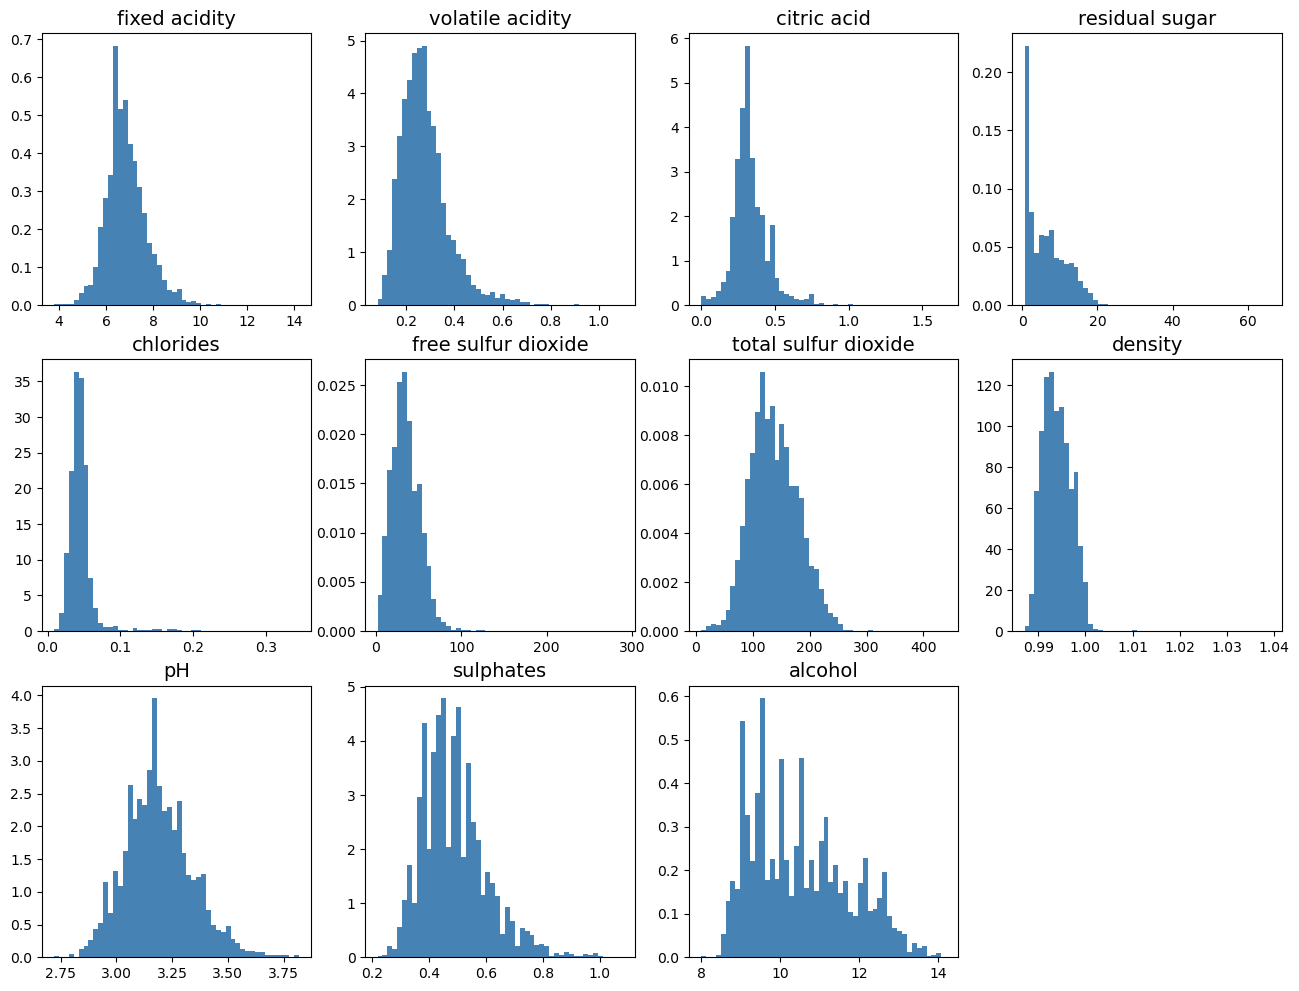

In [8]:
fig = plt.figure(figsize=(16, 12))
for feat_idx in range(X.shape[1]):
    ax = fig.add_subplot(3,4, (feat_idx+1))
    h = ax.hist(X[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')
    ax.set_title(data.columns[feat_idx], fontsize=14)

On remarque en particulier que ces variables prennent des valeurs dans des ensembles différents. Par exemple, “sulphates” varie de 0 à 1 tandis que “total sulfur dioxide” varie de 0 à 440. Il va donc nous falloir standardiser les données pour que la deuxième ne domine pas complètement la première.

Nous allons commencer par transformer ce problème en un problème de classification : il s’agira de séparer les bons vins des vins médiocres :

In [11]:
y_class = np.where(y<6, 0, 1)

Séparons nos données en un jeu d’entraînement et un jeu de test. Le jeu de test contiendra 30% des données.

In [13]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y_class,	test_size=0.3)

Nous pouvons maintenant standardiser les données d’entraînement et appliquer la même transformation aux données de test :

In [15]:
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

On peut visualiser de nouveau les données pour vérifier que les différentes variables prennent des valeurs qui ont maintenant des ordres de grandeur similaires.

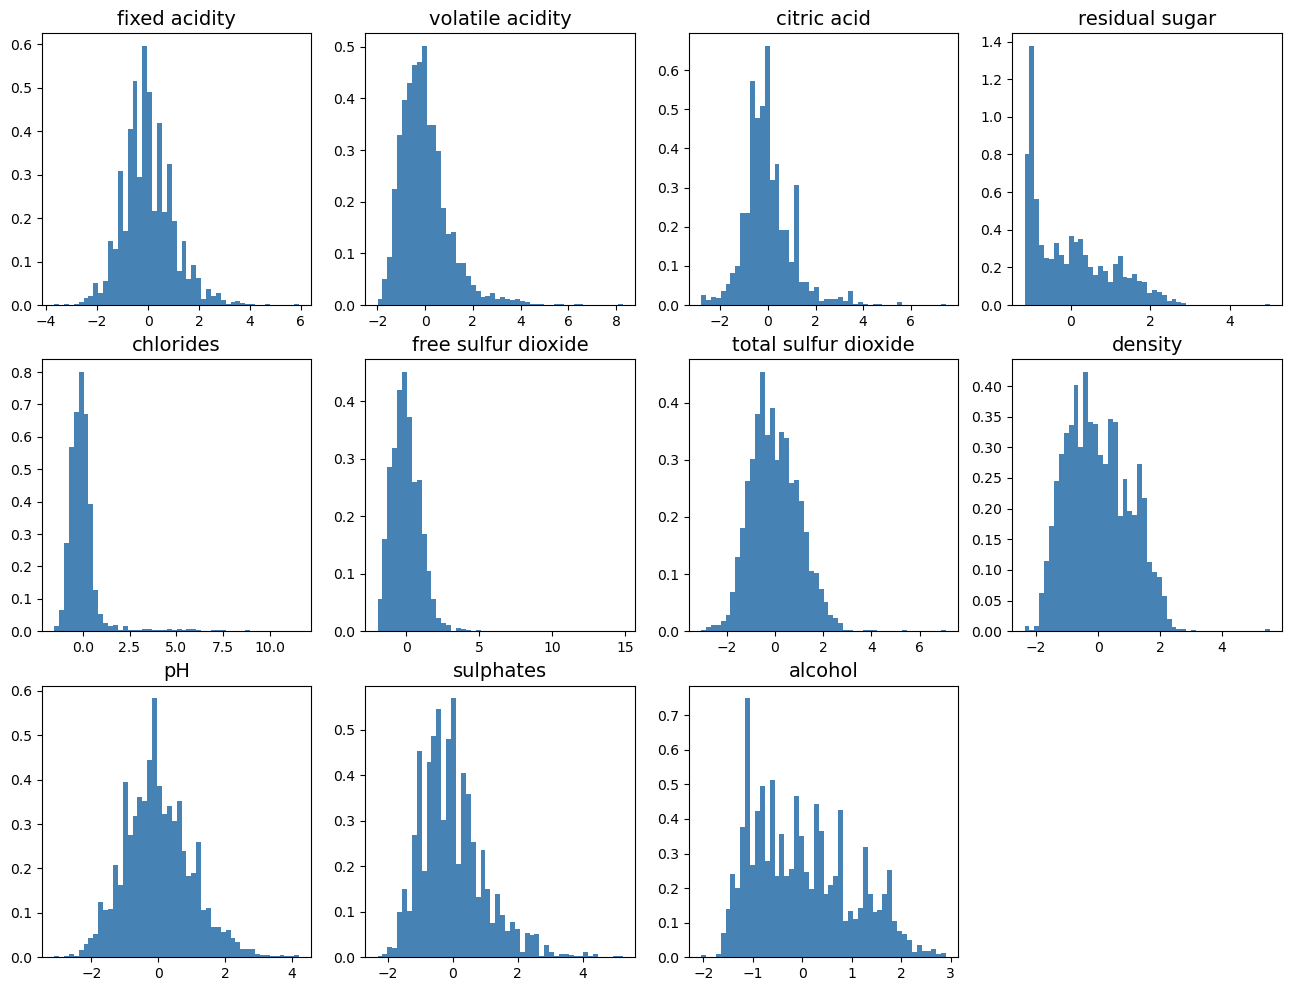

In [17]:
fig = plt.figure(figsize=(16, 12))
for feat_idx in range(X_train_std.shape[1]):
    ax = fig.add_subplot(3,4, (feat_idx+1))
    h = ax.hist(X_train_std[:, feat_idx], bins=50, color = 'steelblue', density=True, edgecolor='none')
    ax.set_title(data.columns[feat_idx], fontsize=14)

Nous allons maintenant utiliser la méthode "GridSearchCV" pour faire une validation croisée du paramètre k d’un kNN (le nombre de plus proches voisins) sur le jeu d’entraînement :

In [19]:
from sklearn import neighbors, metrics

# Fixer les valeurs des hyperparamètres à tester
param_grid = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15]}

# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = 'accuracy'

# Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
clf = model_selection.GridSearchCV(
    neighbors.KNeighborsClassifier(), # un classifieur kNN
    param_grid,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    scoring=score   # score à optimiser
)

# Optimiser ce classifieur sur le jeu d'entraînement
clf.fit(X_train_std, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(clf.best_params_)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        clf.cv_results_['mean_test_score'], # score moyen
        clf.cv_results_['std_test_score'],  # écart-type du score
        clf.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'n_neighbors': 11}
Résultats de la validation croisée :
accuracy = 0.757 (+/-0.026) for {'n_neighbors': 3}
accuracy = 0.757 (+/-0.025) for {'n_neighbors': 5}
accuracy = 0.764 (+/-0.040) for {'n_neighbors': 7}
accuracy = 0.763 (+/-0.041) for {'n_neighbors': 9}
accuracy = 0.766 (+/-0.037) for {'n_neighbors': 11}
accuracy = 0.762 (+/-0.030) for {'n_neighbors': 13}
accuracy = 0.757 (+/-0.037) for {'n_neighbors': 15}


Nous pouvons maintenant regarder la performance sur le jeu de test. GridSearchCV a automatiquement ré-entraîné le meilleur modèle sur l’intégralité du jeu d’entraînement,

In [21]:
y_pred = clf.predict(X_test_std)
print("\nSur le jeu de test : {:.3f}".format(metrics.accuracy_score(y_test, y_pred)))


Sur le jeu de test : 0.756


# Entraînez-vous : implémentez une validation croisée

L’algorithme devra permettre d’optimiser l’accuracy du modèle. La fonction prendra en entrée le tableau des hyperparamètres à tester ainsi que le nombre de folds. On utilisera des folds exacts (non randomisé) afin de pouvoir comparer les résultats.

In [24]:
def cross_validation(param_grid, nbFolds):   

    # Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
    score = 'accuracy'
    
    # Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
    clf = model_selection.GridSearchCV(
        neighbors.KNeighborsClassifier(), # un classifieur kNN
        param_grid,     # hyperparamètres à tester
        cv=nbFolds,           # nombre de folds de validation croisée
        scoring=score   # score à optimiser
    )
    
    # Optimiser ce classifieur sur le jeu d'entraînement
    clf.fit(X_train_std, y_train)
    
    # Afficher le(s) hyperparamètre(s) optimaux
    print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
    print(clf.best_params_)
    
    # Afficher les performances correspondantes
    print("Résultats de la validation croisée :")
    for mean, std, params in zip(
            clf.cv_results_['mean_test_score'], # score moyen
            clf.cv_results_['std_test_score'],  # écart-type du score
            clf.cv_results_['params']           # valeur de l'hyperparamètre
        ):
    
        print("{} = {:.3f} (+/-{:.03f}) for {}".format(
            score,
            mean,
            std*2,
            params
        ) )

    y_pred = clf.predict(X_test_std)
    print("\nSur le jeu de test : {:.3f}".format(metrics.accuracy_score(y_test, y_pred)))

In [25]:
param_grid = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15]}
for i in range(2, 10):
    print("NB FOLDS =", i)
    cross_validation(param_grid, i)

NB FOLDS = 2
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'n_neighbors': 7}
Résultats de la validation croisée :
accuracy = 0.749 (+/-0.018) for {'n_neighbors': 3}
accuracy = 0.750 (+/-0.013) for {'n_neighbors': 5}
accuracy = 0.751 (+/-0.023) for {'n_neighbors': 7}
accuracy = 0.748 (+/-0.008) for {'n_neighbors': 9}
accuracy = 0.748 (+/-0.010) for {'n_neighbors': 11}
accuracy = 0.750 (+/-0.008) for {'n_neighbors': 13}
accuracy = 0.750 (+/-0.004) for {'n_neighbors': 15}

Sur le jeu de test : 0.760
NB FOLDS = 3
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'n_neighbors': 7}
Résultats de la validation croisée :
accuracy = 0.753 (+/-0.022) for {'n_neighbors': 3}
accuracy = 0.757 (+/-0.024) for {'n_neighbors': 5}
accuracy = 0.763 (+/-0.027) for {'n_neighbors': 7}
accuracy = 0.762 (+/-0.036) for {'n_neighbors': 9}
accuracy = 0.756 (+/-0.031) for {'n_neighbors': 11}
accuracy = 0.756 (+/-0.026) for {'n_neighbors': 13}
accuracy = 0.758 (+/-0.024) for {'n_neighbors': 15}


# Évaluez un algorithme de classification qui retourne des scores

**la courbe ROC, pour « Receiver-Operator Characteristic ».**

Text(0, 0.5, 'Sensibilite')

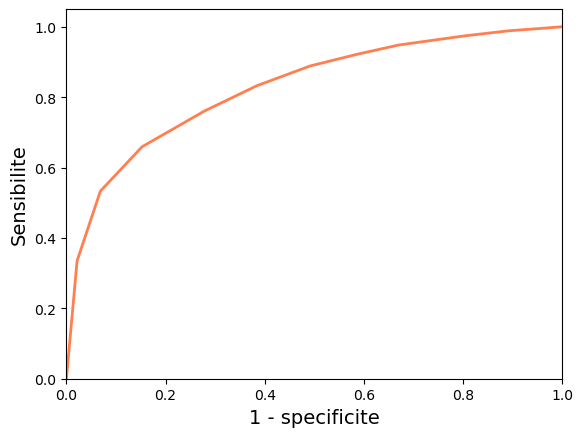

In [28]:
y_pred_proba = clf.predict_proba(X_test_std)[:, 1]
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite', fontsize=14)
plt.ylabel('Sensibilite', fontsize=14)

On peut résumer la courbe ROC par un nombre : "l'aire sous la courbe", aussi dénotée AUROC pour « Area Under the ROC », qui permet plus aisément de comparer plusieurs modèles.

Un classifieur parfait a une AUROC de 1 ; un classifieur aléatoire, une AUROC de 0.5

In [30]:
print(metrics.auc(fpr, tpr))

0.8265734651024692


In [31]:
# indice du premier seuil pour lequel
# la sensibilité est supérieure à 0.95
idx = np.min(np.where(tpr > 0.95)) 

print("Sensibilité : {:.2f}".format(tpr[idx]))
print("Spécificité : {:.2f}".format(1-fpr[idx]))
print("Seuil : {:.2f}".format(thr[idx]))

Sensibilité : 0.97
Spécificité : 0.20
Seuil : 0.27


# Comparez votre algorithme à des approches de régression naïves

**TP : Comparez un modèle kNN à des approches naïves**

In [34]:
data = pd.read_csv('winequality-white.csv', sep=";")
X = data[data.columns[:-1]].values
y = data['quality'].values

Séparons nos données en un jeu de test et un jeu d'entraînement :

In [36]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3 ) # 30% des données dans le jeu de test

Standardisons les données :

In [38]:
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

Entraînons un kNN avec k=11 sur ces données :

In [40]:
from sklearn import neighbors
knn = neighbors.KNeighborsRegressor(n_neighbors=11)

knn.fit(X_train_std, y_train)

KNeighborsRegressor(n_neighbors=11)

Et appliquons le pour prédire les étiquettes de notre jeu de test :

In [42]:
y_pred = knn.predict(X_test_std)

Calculons la RMSE correspondante :

In [44]:
print("RMSE : {:.2f}".format(np.sqrt( metrics.mean_squared_error(y_test, y_pred) )))

RMSE : 0.71


Nos étiquettes étant des nombres entiers, nous faisons en moyenne une erreur inférieure à la plus petite différence possible entre deux notes.

Nous pouvons visualiser les résultats sur un graphique, en représentant en abscisse les vraies valeurs des étiquettes, et en ordonnée les valeurs prédites.

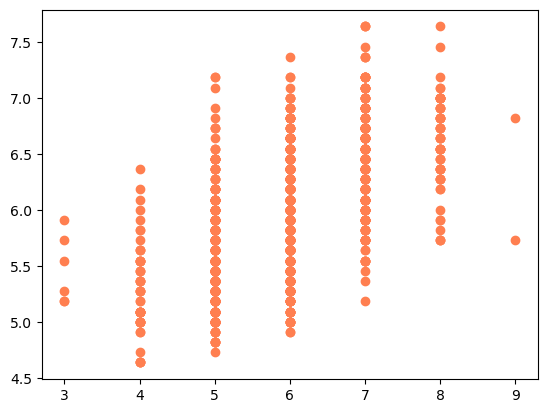

In [46]:
plt.scatter(y_test, y_pred, color='coral')

Comme nos étiquettes prennent des valeurs entières entre 3 et 8, nous avons beaucoup de points superposés aux même coordonnées. Pour mieux visualiser les données, nous pouvons utiliser comme marqueurs des cercles dont la taille est proportionnelle au nombre de points qui sont présents à ces coordonnées.

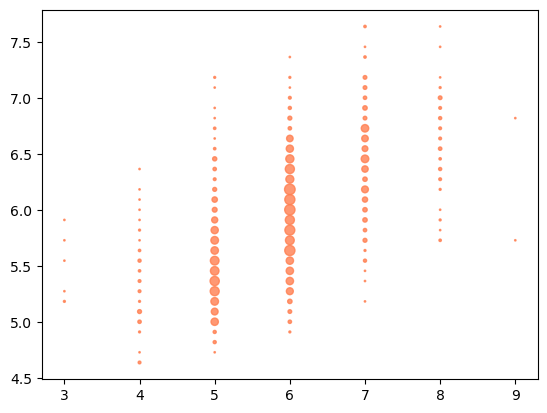

In [48]:
sizes = {} # clé : coordonnées ; valeur : nombre de points à ces coordonnées
for (yt, yp) in zip(list(y_test), list(y_pred)):
    if (yt, yp) in sizes:
        sizes[(yt, yp)] += 1
    else:
        sizes[(yt, yp)] = 1

keys = sizes.keys()
plt.scatter(
        [k[0] for k in keys], # vraie valeur (abscisse)
        [k[1] for k in keys], # valeur predite (ordonnee)
        s=[sizes[k] for k in keys], # taille du marqueur
        color='coral', alpha =0.8)

Pour mieux comprendre notre modèle, comparons-le à une première approche naïve, qui consiste à prédire des valeurs aléatoires, distribuées uniformément entre les valeurs basse et haute des étiquettes du jeu de données d'entraînement.

In [50]:
y_pred_random = np.random.randint(np.min(y), np.max(y), y_test.shape)

Calculons la RMSE correspondante :

In [52]:
print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y_test, y_pred_random))))

RMSE : 1.92


Cette valeur est plus grande que notre 1er modèle. Notre modèle a ainsi réussi à bien mieux apprendre qu'un modèle aléatoire.

Cependant, beaucoup de nos vins ont une note de 6, et beaucoup de nos prédictions sont autour de cette valeur. Comparons maintenant notre modèle à un modèle aléatoire qui retourne systématiquement la valeur moyenne des étiquettes du jeu de données d'entraînement.

Nous pouvons utiliser pour cela la fonction correspondante du module "dummy" de scikit-learn.

In [55]:
from sklearn import dummy
dum = dummy.DummyRegressor(strategy='mean')

# Entraînement
dum.fit(X_train_std, y_train)

# Prédiction sur le jeu de test
y_pred_dum = dum.predict(X_test_std)

# Evaluate
print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y_test, y_pred_dum)) ))

RMSE : 0.89


Le kNN a donc appris plus que la moyenne des étiquettes…

# Entraînez-vous : sélectionnez le nombre de voisins dans un kNN pour une régression

In [58]:
data = pd.read_csv('winequality-white.csv', sep=";")
X = data[data.columns[:-1]].values
y = data['quality'].values

In [59]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3 ) # 30% des données dans le jeu de test

In [60]:
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

In [61]:
# Fixer les valeurs des hyperparamètres à tester
param_grid = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15]}

# Choisir un score à optimiser, ici le MSE
scoring = {'neg_mean_squared_error': 'neg_mean_squared_error', 'r2': 'r2'}

# Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
clf = model_selection.GridSearchCV(
    neighbors.KNeighborsRegressor(), # un classifieur kNN
    param_grid,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    scoring=scoring,   # score à optimiser
    refit='neg_mean_squared_error'                   # définir quel score utiliser pour refit et best_params_
)

# Optimiser ce classifieur sur le jeu d'entraînement
clf.fit(X_train_std, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(clf.best_params_)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for score_name in scoring.keys():
    print(f"\nScores pour '{score_name}':")
    for mean, std, params in zip(
            clf.cv_results_[f'mean_test_{score_name}'],  # score moyen pour chaque score
            clf.cv_results_[f'std_test_{score_name}'],   # écart-type du score
            clf.cv_results_['params']                    # valeur de l'hyperparamètre
    ):
        print(f"{score_name} = {mean:.3f} (+/-{std * 2:.03f}) for {params}")


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'n_neighbors': 15}
Résultats de la validation croisée :

Scores pour 'neg_mean_squared_error':
neg_mean_squared_error = -0.581 (+/-0.059) for {'n_neighbors': 3}
neg_mean_squared_error = -0.547 (+/-0.050) for {'n_neighbors': 5}
neg_mean_squared_error = -0.540 (+/-0.038) for {'n_neighbors': 7}
neg_mean_squared_error = -0.541 (+/-0.044) for {'n_neighbors': 9}
neg_mean_squared_error = -0.542 (+/-0.043) for {'n_neighbors': 11}
neg_mean_squared_error = -0.535 (+/-0.051) for {'n_neighbors': 13}
neg_mean_squared_error = -0.535 (+/-0.057) for {'n_neighbors': 15}

Scores pour 'r2':
r2 = 0.263 (+/-0.069) for {'n_neighbors': 3}
r2 = 0.305 (+/-0.079) for {'n_neighbors': 5}
r2 = 0.315 (+/-0.072) for {'n_neighbors': 7}
r2 = 0.314 (+/-0.051) for {'n_neighbors': 9}
r2 = 0.312 (+/-0.042) for {'n_neighbors': 11}
r2 = 0.321 (+/-0.033) for {'n_neighbors': 13}
r2 = 0.322 (+/-0.033) for {'n_neighbors': 15}


Le meilleur r2 est aussi pour le 7

Comparaison avec baseline naive :

In [64]:
data = pd.read_csv('winequality-red.csv', sep=";")
X = data[data.columns[:-1]].values
y = data['quality'].values

In [65]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3 ) # 30% des données dans le jeu de test

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

# Fixer les valeurs des hyperparamètres à tester
param_grid = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15]}

# Choisir un score à optimiser, ici le MSE
scoring = {'neg_mean_squared_error': 'neg_mean_squared_error', 'r2': 'r2'}

# Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
clf = model_selection.GridSearchCV(
    neighbors.KNeighborsRegressor(), # un classifieur kNN
    param_grid,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    scoring=scoring,   # score à optimiser
    refit='neg_mean_squared_error'                   # définir quel score utiliser pour refit et best_params_
)

# Optimiser ce classifieur sur le jeu d'entraînement
clf.fit(X_train_std, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(clf.best_params_)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for score_name in scoring.keys():
    print(f"\nScores pour '{score_name}':")
    for mean, std, params in zip(
            clf.cv_results_[f'mean_test_{score_name}'],  # score moyen pour chaque score
            clf.cv_results_[f'std_test_{score_name}'],   # écart-type du score
            clf.cv_results_['params']                    # valeur de l'hyperparamètre
    ):
        print(f"{score_name} = {mean:.3f} (+/-{std * 2:.03f}) for {params}")

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'n_neighbors': 15}
Résultats de la validation croisée :

Scores pour 'neg_mean_squared_error':
neg_mean_squared_error = -0.517 (+/-0.068) for {'n_neighbors': 3}
neg_mean_squared_error = -0.464 (+/-0.079) for {'n_neighbors': 5}
neg_mean_squared_error = -0.447 (+/-0.078) for {'n_neighbors': 7}
neg_mean_squared_error = -0.433 (+/-0.075) for {'n_neighbors': 9}
neg_mean_squared_error = -0.428 (+/-0.070) for {'n_neighbors': 11}
neg_mean_squared_error = -0.425 (+/-0.060) for {'n_neighbors': 13}
neg_mean_squared_error = -0.420 (+/-0.062) for {'n_neighbors': 15}

Scores pour 'r2':
r2 = 0.174 (+/-0.186) for {'n_neighbors': 3}
r2 = 0.260 (+/-0.181) for {'n_neighbors': 5}
r2 = 0.287 (+/-0.178) for {'n_neighbors': 7}
r2 = 0.309 (+/-0.177) for {'n_neighbors': 9}
r2 = 0.318 (+/-0.163) for {'n_neighbors': 11}
r2 = 0.323 (+/-0.144) for {'n_neighbors': 13}
r2 = 0.332 (+/-0.130) for {'n_neighbors': 15}


Entraînons un knn avec k = 13 , qui est le meilleur score ci-dessus

In [67]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3 ) # 30% des données dans le jeu de test

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

knn = neighbors.KNeighborsRegressor(n_neighbors=13)

knn.fit(X_train_std, y_train)

KNeighborsRegressor(n_neighbors=13)

prédire les étiquettes : 

In [69]:
y_pred = knn.predict(X_test_std)

In [70]:
print("RMSE : {:.2f}".format(np.sqrt( metrics.mean_squared_error(y_test, y_pred) )))

RMSE : 0.68


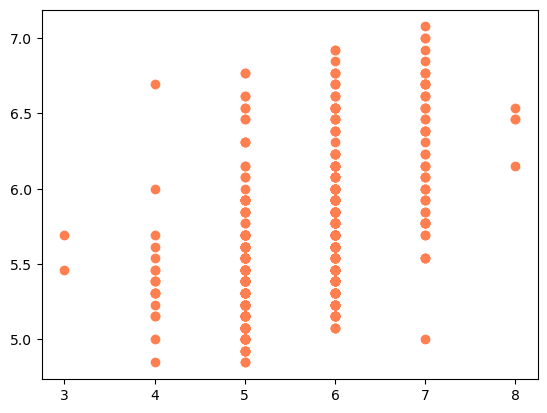

In [71]:
plt.scatter(y_test, y_pred, color='coral')

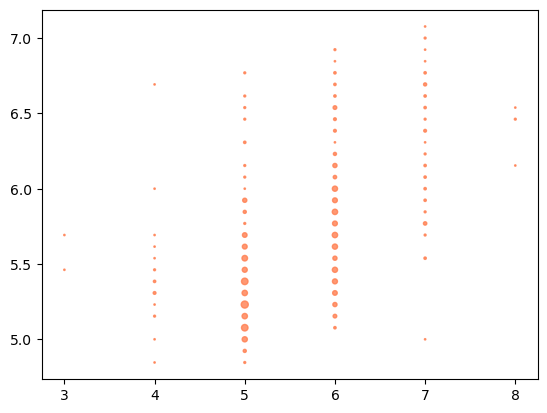

In [72]:
sizes = {} # clé : coordonnées ; valeur : nombre de points à ces coordonnées
for (yt, yp) in zip(list(y_test), list(y_pred)):
    if (yt, yp) in sizes:
        sizes[(yt, yp)] += 1
    else:
        sizes[(yt, yp)] = 1

keys = sizes.keys()
plt.scatter(
        [k[0] for k in keys], # vraie valeur (abscisse)
        [k[1] for k in keys], # valeur predite (ordonnee)
        s=[sizes[k] for k in keys], # taille du marqueur
        color='coral', alpha =0.8)

avec une base naive :

In [74]:
y_pred_random = np.random.randint(np.min(y), np.max(y), y_test.shape)

In [75]:
print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y_test, y_pred_random))))

RMSE : 1.66


Comparons maintenant notre modèle à un modèle aléatoire qui retourne systématiquement la valeur moyenne des étiquettes du jeu de données d'entraînement.

In [77]:
from sklearn import dummy
dum = dummy.DummyRegressor(strategy='mean')

# Entraînement
dum.fit(X_train_std, y_train)

# Prédiction sur le jeu de test
y_pred_dum = dum.predict(X_test_std)

# Evaluate
print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y_test, y_pred_dum)) ))

RMSE : 0.79


# TP - Comparez le comportement du lasso et de la régression ridge

In [121]:
data = pd.read_csv('TP_1_prostate_dataset.csv', sep="\t")
data.head()

,col,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
3,4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
4,5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


**Sélection des features et de la cible :**

In [124]:
X = data.iloc[:, 1:-3]
y = data.iloc[:, -2]

**On standardise les valeurs :**

In [158]:
std_scale = preprocessing.StandardScaler().fit(X)
X_scale = std_scale.transform(X)

In [160]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_scale, y, test_size=0.25 ) # 25% des données dans le jeu de test

In [209]:
X_train = data.iloc[:60,1:-3]
y_train = data.iloc[:60,-2]
X_test = data.iloc[60:,1:-3]
y_test = data.iloc[60:,-2]

In [193]:
X_train.shape

(72, 7)

In [197]:
X_test.shape

(25, 7)

**Baseline : une régression linéeaire classique :**

La première étape est d'effectuer une régression linéaire classique afin de récupérer une erreur baseline, qu'on souhaite améliorer à l'aide des techniques de régularisation.

In [211]:
from sklearn import linear_model

lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [213]:
baseline_error = np.mean((lr.predict(X_test) - y_test) **2)
print(baseline_error)

2.8641499657014413


**Application de la régression ridge**

On doit trouver un coefficient de régularisation adapté. Pour rappel, l'objectif est de biaiser un peu la prédiction, afin de diminuer l'erreur standard. 

On appelle ce coefficient alpha, on va en tester un certain nombre afin de trouver celui qui est optimal

In [215]:
n_alphas = 200
alphas = np.logspace(-5, 5, n_alphas)

On peut maintenant tester toute les régressions ridges avec les différentes valeur de l'hyperparamètre α
 . On récupère les poids des différents coefficients de la régression associées ainsi que l'erreur quadratique.

In [217]:
from sklearn.linear_model import Ridge
ridge = linear_model.Ridge()

coefs = []
errors = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    errors.append([baseline_error, np.mean((ridge.predict(X_test) - y_test) ** 2)])

On peut afficher l'évolution de la valeur des différents poids associés aux paramètres

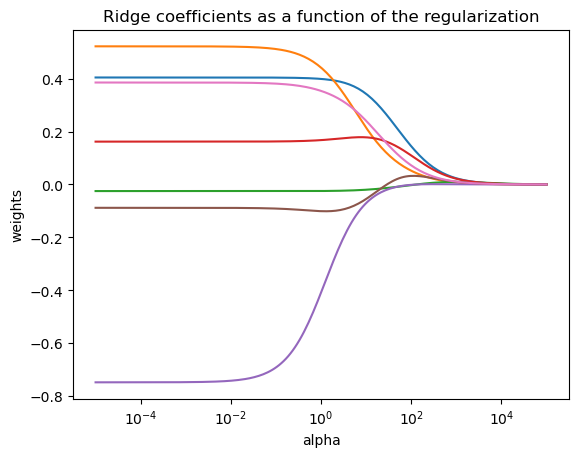

In [219]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

Comme on peut le voir (et comme c'était prévu), la valeur de alpha diminue les poids de tous les paramètres de la régression. Etudions maintenant la valeur de l'erreur quadratique

En bleu, c'est la baseline error.

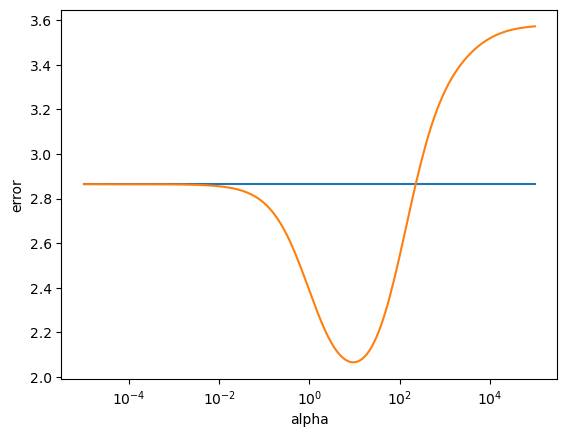

In [221]:
ax = plt.gca()

ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.axis('tight')
plt.show()

In [234]:
min(errors)[1]

2.064827060795023

L'erreur ridge est plus petite que la baseline.

Pour effectuer une cross validation de la régression ridge, vous pouvez utiliser la fonction sklearn.linear_model.RidgeCVqui effectue une recherche automatique des hyperparamètres. J'ai ici effectué une recherche manuelle pour le TP.

**Application du Lasso**

On teste aussi un certain nombre d'hyperparamètres pour appliquer le lasso

In [242]:
n_alphas = 300
alphas = np.logspace(-5, 1, n_alphas)
lasso = linear_model.Lasso(fit_intercept=False)

coefs = []
errors = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    errors.append([baseline_error, np.mean((lasso.predict(X_test) - y_test) ** 2)])

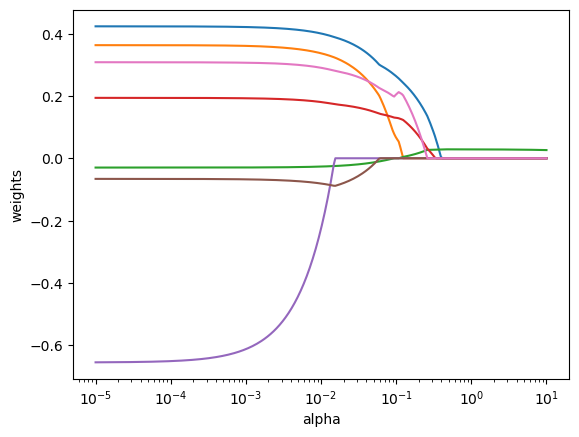

In [244]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.axis('tight')
plt.show()

Comme on peut le voir, le lasso permet de supprimer des variables en mettant leur poids à zéro. C'est le cas si deux variables sont corrélées. L'une sera sélectionnée par le Lasso, l'autre supprimée. C'est aussi son avantage par rapport à une régression ridge qui ne fera pas de sélection de variables.

On peut observer maintenant le comportement de l'erreur.

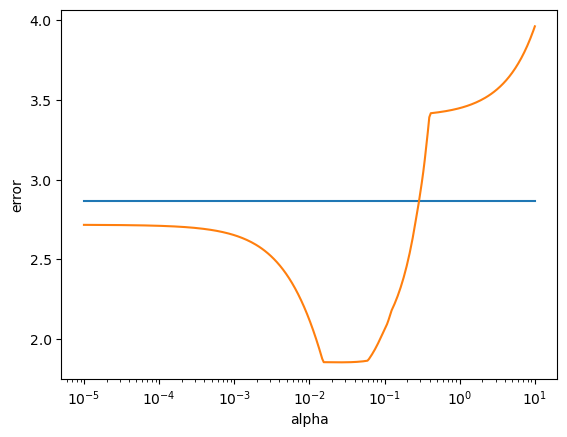

In [247]:
ax = plt.gca()

ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.axis('tight')
plt.show()

In [249]:
min(errors)[1]

1.8531561201728377

On fait encore mieux qu'avec la régression ridge! En effet comme vu dans les chapitres précédents, le lasso a pour avantage de pouvoir sélectionner un sous-ensemble des variables explicatives afin de permettre une meilleur généralisation.

De même, la fonction sklearn.linear_model.LassoCVpermet d'effectuer une recherche des hyperparamètres de manière automatisée